In [8]:
from pathlib import Path

import numpy as np
import pandas as pd 
import xarray as xr

import config.settings as cset
from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            focus_countries,
                            focus_countries_names,
                            focus_countries_colors, 
                            focus_scenarios_color_dict,
                            focus_scenarios_labels,
                            focus_scenarios,
                            cmap_diverging,
                            cmap_negref
                            )

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box
from matplotlib.gridspec import GridSpec

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['ps.fonttype'] = 'truetype'

## Load Data

a. GMT

In [9]:
gmt_ds = pd.read_csv(cset.path_MESMER_char / f'gmt_dataset.csv', index_col = 0)


## Plot

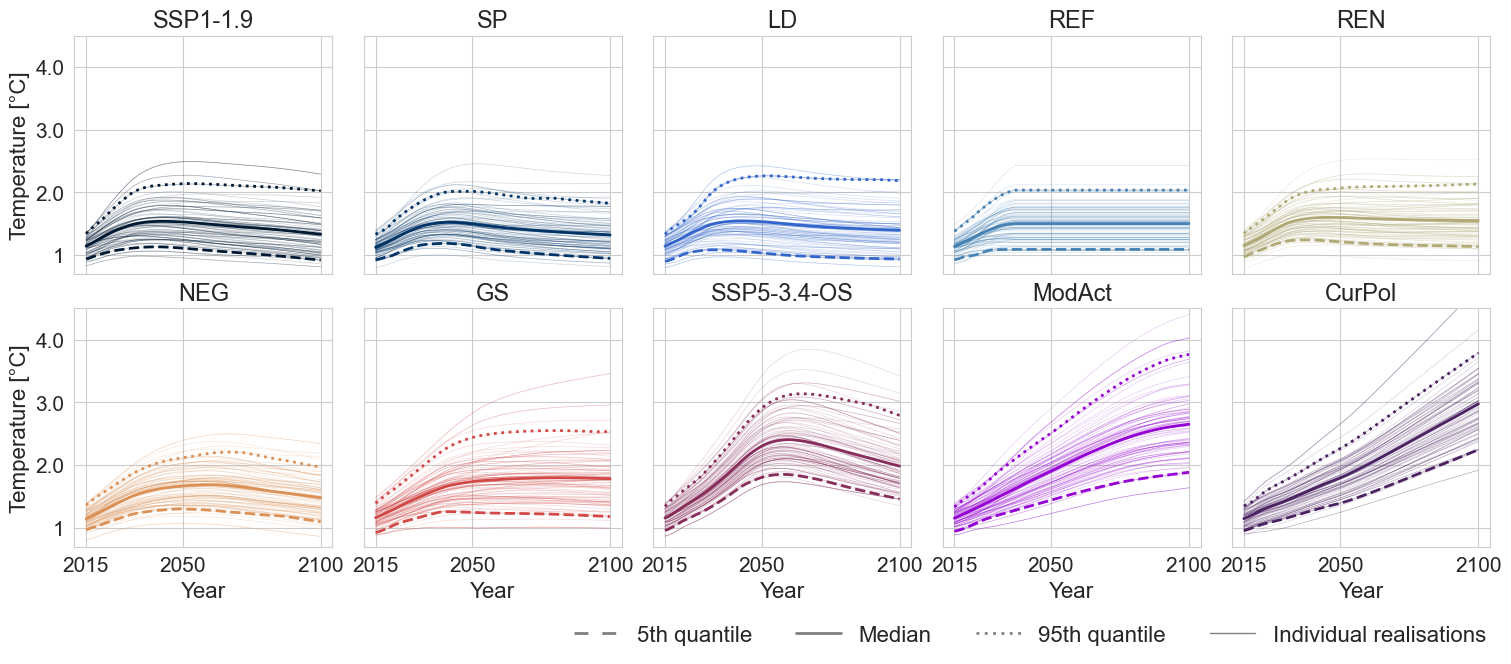

In [10]:
import matplotlib.lines as mlines

with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
    
    for i, ax in enumerate(axes.flatten()):
        scenario = cset.scenarios[i]
        color = cset.scenarios_color_dict[scenario]

        ax.plot(gmt_ds.index, 
                gmt_ds.loc[:, gmt_ds.columns.str.contains(scenario)].values, 
                color = color,
                alpha = .2,
                lw = 0.5)

        ax.plot(gmt_ds.index, 
                gmt_ds.loc[:, gmt_ds.columns.str.contains(scenario)].values.mean(axis = 1), 
                color = color,
                lw = 2)
        ax.plot(gmt_ds.index, 
                np.quantile(gmt_ds.loc[:, gmt_ds.columns.str.contains(scenario)].values, q = 0.05, axis = 1), 
                color = color,
                linestyle = '--',
                lw = 2)
        ax.plot(gmt_ds.index, 
                np.quantile(gmt_ds.loc[:, gmt_ds.columns.str.contains(scenario)].values, q = 0.95, axis = 1), 
                color = color,
                linestyle = 'dotted',
                lw = 2)
        if i%5 == 0: 
            ax.set_yticks([1, 2.0, 3.0, 4.0], 
                        [1, 2.0, 3.0, 4.0], 
                        fontsize=labelsize_small)
            ax.set_ylabel('Temperature [°C]', 
                        fontsize=labelsize_medium)
            ax.set_ylabel('Temperature [°C]', 
                        fontsize=labelsize_medium)
        else: 
            ax.set_yticks([1, 2.0, 3.0, 4.0,], 
                          [])
        
        if i < 5: 
            ax.set_xticks([2015, 2050, 2100],
                        [])
        else:
            ax.set_xticks([2015, 2050, 2100],
                        [2015, 2050, 2100],
                        fontsize=labelsize_small)
            ax.set_xlabel('Year', 
                        fontsize=labelsize_medium)
        ax.set_title(cset.scenario_names_dict[scenario], 
                    fontsize = labelsize_large)
        ax.set_ylim(0.7,4.5)

    # add a legend 
    line_styles = {
            "5th quantile": (0, (5, 5)),   # dashed
            "Median": '-',                  # solid
            "95th quantile": (0, (1, 2)),  # dotted    
    }
    color = "grey"
    legend_lines = [plt.Line2D([0], [0], color=color, linestyle=line_styles[label], linewidth=2) for label in line_styles]
    legend_lines += [mlines.Line2D([], [], color=color, linestyle='-', linewidth=1, label='Individual realiations')]
    legend_labels = list(line_styles.keys()) + ['Individual realisations']
    
    fig.legend(legend_lines, 
               legend_labels,
               bbox_to_anchor = (1, 0),
               facecolor = (1,1,1,0.7),
               edgecolor = 'none', 
               fontsize = labelsize_medium, 
               ncols = 4)
    Path(cset.path_GRAPHICS / 'appendix').mkdir(exist_ok = True)
    plt.savefig(cset.path_GRAPHICS / 'appendix' / 'GMT_by_scenario.pdf', dpi = 600)
    plt.show()

## Table 

In [11]:
thrshld = 1.35
thrshld_str = '135'
gmt_char_df = pd.read_csv(cset.path_MESMER_char / f'gmt_characteristics_thsld_{thrshld_str}.csv', index_col = 0)

In [12]:
publication_df = pd.DataFrame(index = cset.scenario_names, columns = ['EOC', 'EOC 5th', 'EOC 95th', 'MAX', 'MAX 5th', 'MAX 95th', 'CED', 'CED 5th', 'CED 95th'])

In [13]:
for scenario in cset.scenarios: 
    scenario_name = cset.scenario_names_dict[scenario]
    tmp_df = np.round(gmt_char_df.loc[gmt_char_df.index.str.contains(scenario), ['gmt_eoc', 'gmt_max', 'gmt_exc']].quantile([0.5, 0.05, 0.95], axis = 0).copy(),2)
    for prop_publi, prop_char in zip(['EOC', 'MAX', 'CED'], ['gmt_eoc', 'gmt_max', 'gmt_exc']):
        publication_df.loc[scenario_name, [f'{prop_publi}', f'{prop_publi} 5th', f'{prop_publi} 95th']] = tmp_df.loc[0.5, prop_char], tmp_df.loc[0.05, prop_char], tmp_df.loc[0.95, prop_char]

In [14]:
for col in publication_df.columns: 
    publication_df.loc[:,col] = publication_df[col].map("{:.2f}".format)

In [15]:
from tabulate import tabulate

with open(cset.path_GRAPHICS / 'appendix' / 'GMT_char.txt', 'w') as f:
    f.write(tabulate(publication_df, tablefmt='latex'))